In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
df = pd.read_csv('Data.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


C:\Users\user\AppData\Local\Temp\ipykernel_2220\3530229682.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(count_text, alpha=1, palette=['blue', "red"])


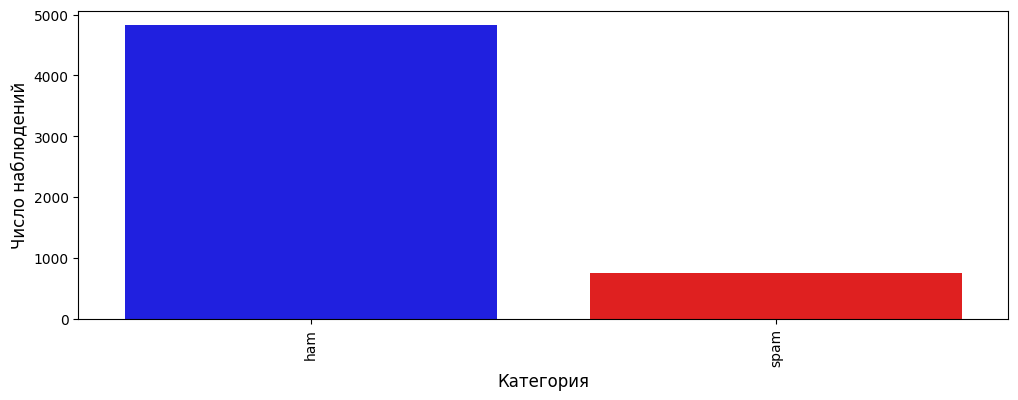

In [4]:
count_text = df['Category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(count_text, alpha=1, palette=['blue', "red"])
plt.ylabel('Число наблюдений', fontsize=12)
plt.xlabel('Категория', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [5]:
replace_dict = {
    "ham": 0,
    "spam": 1
}

In [6]:
df["Category"] = df["Category"].replace(replace_dict) 
df

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [7]:
df.to_csv('NewData.csv')

In [8]:
df = pd.read_csv('NewData.csv')

In [9]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [11]:
df['Message'] = df['Message'].apply(preprocess_text)

category = df['Category'].values
message = df['Message'].values

In [177]:
tokenizer = Tokenizer(num_words=None, char_level=True, lower=False)
tokenizer.fit_on_texts(message)
sequences = tokenizer.texts_to_sequences(message)

In [178]:
data = pad_sequences(sequences, maxlen=175)

In [179]:
train_data, test_data, train_category, test_category = train_test_split(data, category, test_size=0.2, random_state=72) 

In [189]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, 220, input_length=175))
model.add(LSTM(150, dropout=0.1, return_sequences=True))
model.add(Dense(100, activation='relu')) 
model.add(Dropout(0.3))
model.add(LSTM(100, dropout=0.1, return_sequences=True))
model.add(Dense(80, activation='relu')) 
model.add(Dropout(0.3))
model.add(LSTM(70, dropout=0.1)) #, return_sequences=True
#model.add(Dense(40, activation='relu')) 
#model.add(Dropout(0.1))
#model.add(LSTM(50, dropout=0.1))
#model.add(Dense(20, activation='relu')) 
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [190]:
history = model.fit(train_data, train_category, validation_split=0.2, epochs=5, verbose=1)

Epoch 1/5
112/112 [==============================] - 50s 400ms/step - loss: 0.1841 - accuracy: 0.9338 - val_loss: 0.0999 - val_accuracy: 0.9753
Epoch 2/5
112/112 [==============================] - 43s 388ms/step - loss: 0.0980 - accuracy: 0.9742 - val_loss: 0.1184 - val_accuracy: 0.9709
Epoch 3/5
112/112 [==============================] - 45s 403ms/step - loss: 0.1188 - accuracy: 0.9649 - val_loss: 0.1065 - val_accuracy: 0.9731
Epoch 4/5
112/112 [==============================] - 43s 384ms/step - loss: 0.1025 - accuracy: 0.9742 - val_loss: 0.0944 - val_accuracy: 0.9742
Epoch 5/5
112/112 [==============================] - 43s 387ms/step - loss: 0.1047 - accuracy: 0.9689 - val_loss: 0.2923 - val_accuracy: 0.8610


In [191]:
loss, accuracy = model.evaluate(test_data, test_category, verbose=1)

print(f"Ошибка: {loss}")
print(f"Точность: {accuracy}")

35/35 [==============================] - 3s 73ms/step - loss: 0.2879 - accuracy: 0.8717
Ошибка: 0.28787821531295776
Точность: 0.8717488646507263


In [192]:
predictions = model.predict(test_data)
binary_predictions = np.where(predictions > 0.5, 1, 0)
results = pd.DataFrame({
    'True Label': test_category,
    'Predicted Label': binary_predictions.flatten()
})
results.to_csv('test_results.csv', index=False)

total_records = len(results)
mismatch_records = len(results[results['True Label'] != results['Predicted Label']])
percent_loss = mismatch_records / total_records * 100
print(f'Число записей: {total_records}')
print(f'Число не совпадающих результатов: {mismatch_records}')
print(f'Процент ошибочных предсказаний: {percent_loss}')

35/35 [==============================] - 3s 73ms/step
Число записей: 1115
Число не совпадающих результатов: 143
Процент ошибочных предсказаний: 12.825112107623319


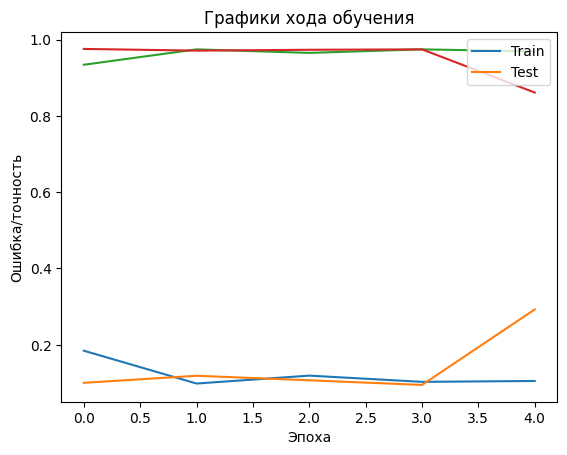

In [193]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Графики хода обучения')
plt.ylabel('Ошибка/точность')
plt.xlabel('Эпоха')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [147]:
model.save('model2')
model.summary()

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 175, 120)          5520      
                                                                 
 lstm_80 (LSTM)              (None, 175, 100)          88400     
                                                                 
 dense_91 (Dense)            (None, 175, 50)           5050      
                                                                 
 dropout_57 (Dropout)        (None, 175, 50)           0         
                                                                 
 lstm_81 (LSTM)              (None, 175, 90)           50760     
                                                                 
 dense_92 (Dense)            (None, 175, 40)           3640      
                                                                 
 dropout_58 (Dropout)        (None, 175, 40)         

In [ ]:
from keras.models import load_model
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

datFr = pd.read_csv('email_spam.csv')
datFr = datFr.drop(datFr.columns[0], axis=1)

replace_dict = {
    "not spam": 0,
    "spam": 1
}
datFr["type"] = datFr["type"].replace(replace_dict) 
datFr

,text,type
0,"Hi James,\n\nHave you claim your complimentary...",1
1,"\nalt_text\nCongratulations, you just earned\n...",0
2,"Here's your GitHub launch code, @Mortyj420!\n ...",0
3,"Hello,\n \nThank you for contacting the Virtua...",0
4,"Hey Prachanda Rawal,\n\nToday's newsletter is ...",1
...,...,...
79,"Dear Maryam, \n\n \n\nI would like to thank yo...",0
80,"Dear Customer,\n\nWelcome to Kilimall, Thanks ...",0
81,"Dear vladis163rus,\nHere is the Steam Guard co...",0
82,View In Browser | Log in\n \n \n\nSkrill logo\...,0


In [196]:
model1 = load_model('model1')

datFr = datFr.rename(columns={'text': 'Message', 'type': 'Label'})

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

datFr['Message'] = datFr['Message'].apply(preprocess_text)

Message = datFr['Message'].values
Label = datFr['Label'].values

tokenizer = Tokenizer(num_words=None, char_level=True, lower=False)
tokenizer.fit_on_texts(Message)
sequences = tokenizer.texts_to_sequences(Message)

data_sequences = pad_sequences(sequences, maxlen=350)
predictions = model1.predict(data_sequences)
binary_predictions = np.where(predictions > 0.5, 'spam', 'ham')

binary_predictions = np.where(predictions >= 0.5, 1, 0)
datFr['Predicted Label'] = binary_predictions

datFr.to_csv('111.csv', index=False)
datFr

3/3 [==============================] - 1s 74ms/step


,Message,Label,Predicted Label
0,hi jame claim complimentari gift yet compil sp...,1,1
1,alt_text congratul earn 500 complet follow off...,0,0
2,github launch code mortyj420 octocat stand nex...,0,1
3,hello thank contact virtual reward center virt...,0,0
4,hey prachanda rawal today newslett jam pack ev...,1,0
...,...,...,...
79,dear maryam would like thank applic role child...,0,0
80,dear custom welcom kilim thank much join us ki...,0,0
81,dear vladis163rus steam guard code need login ...,0,0
82,view browser log skrill logo money mover maker...,0,0


In [197]:
dfres = pd.read_csv('111.csv')

num_rows = len(dfres)

num_1_pre = (dfres['Predicted Label']==1).sum()

counter1 = 0
for index, row in dfres.iterrows():
    if row['Label'] != row['Predicted Label']:
        counter1 += 1
loss = num_rows / 100 * counter1
print(f'Количество строк: {num_rows}')
print(f'Ошибки: {counter1}')
print(f'Loss: {loss}%')

Количество строк: 84
Ошибки: 36
Loss: 30.24%
